In [ ]:
import os
import random
import sys

import numpy as np
import torch
import matplotlib.pyplot as plt

# parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
# sys.path.append(parent_dir)

# Import custom modules
from dino_wm.models.dino_models import VideoTransformer, normalize_acs, select_xyyaw_from_state
from dino_wm.utils.test_loader import SplitTrajectoryDataset
from torch.utils.data import DataLoader
from utils import compare_kdes, load_state_dict_flexible
from torchvision import transforms

# Add directories to system path
# base_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
# sys.path.extend(
#     [
#         base_dir,
#         os.path.join(base_dir, "model_based_irl_torch"),
#         os.path.join(base_dir, "real_envs"),
#     ]
# )

# Load model
print(sys.path)
dino = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg")

['/home/sunny/miniconda3/envs/anysafe/lib/python312.zip', '/home/sunny/miniconda3/envs/anysafe/lib/python3.12', '/home/sunny/miniconda3/envs/anysafe/lib/python3.12/lib-dynload', '', '/home/sunny/miniconda3/envs/anysafe/lib/python3.12/site-packages', '/home/sunny/AnySafe_Reachability', '..', '/tmp/tmpcn3y1nim']


Using cache found in /home/sunny/.cache/torch/hub/facebookresearch_dinov2_main


In [13]:
def transition_from_data(data, transition, device, use_amp=True):
    data1 = data["cam_zed_embd"].to(device)
    data2 = data["cam_rs_embd"].to(device)

    inputs1 = data1[:, :-1]
    inputs2 = data2[:, :-1]

    states = data["state"].to(device)[:, :-1]
    acs = normalize_acs(data["action"].to(device)[:, :-1], device=device)

    with torch.autocast(device_type="cuda", dtype=torch.float32, enabled=use_amp):
        with torch.no_grad():
            pred1, pred2, pred_state, pred_fail, semantic_feat = transition(
                inputs1, inputs2, states, acs
            )

    return pred1, pred2, pred_state, pred_fail, semantic_feat


def data_from_traj(traj):
    data = {}
    segment_length = traj["actions"].shape[0]
    # data["robot0_eye_in_hand_image"] = torch.tensor(
    #     np.array(traj["camera_0"][:]) * 255.0, dtype=torch.uint8
    # )
    data["agentview_image"] = torch.tensor(
        np.array(traj["camera_1"][:]) * 255.0, dtype=torch.uint8
    )
    # data["cam_rs_embd"] = torch.tensor(
    #     np.array(traj["cam_rs_embd"][:]), dtype=torch.float32
    # )
    data["cam_zed_embd"] = torch.tensor(
        np.array(traj["cam_zed_embd"][:]), dtype=torch.float32
    )
    data["state"] = torch.tensor(np.array(traj["states"][:]), dtype=torch.float32)
    data["action"] = torch.tensor(np.array(traj["actions"][:]), dtype=torch.float32)
    if "labels" in traj.keys():
        data["failure"] = torch.tensor(np.array(traj["labels"][:]), dtype=torch.float32)
    data["is_first"] = torch.zeros(segment_length)
    data["is_last"] = torch.zeros(segment_length)
    data["is_first"][0] = 1.0
    data["is_terminal"] = data["is_last"]
    data["discount"] = torch.ones(segment_length, dtype=torch.float32)
    return data


# Define transforms
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform1 = transforms.Compose(
    [
        transforms.Resize(520),
        transforms.CenterCrop(518),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.2),
    ]
)

DINO_transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

norm_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

In [14]:
import torch
import torch.nn.functional as F

def isolate_red_chocolates(images):
    """
    Isolate red chocolates from batched images.
    
    Args:
        images (torch.Tensor): Batched images of shape (B, H, W, 3), values in [0, 1]
        
    Returns:
        masks (torch.Tensor): Binary masks of shape (B, 1, H, W)
    """
    images = images.permute(0, 3, 1, 2)  # Change to (B, C, H, W)
    B, C, H, W = images.shape
    assert C == 3, "Images must have 3 channels (RGB)"
    
    # Convert RGB to HSV (vectorized)
    r, g, b = images[:,0:1], images[:,1:2], images[:,2:3]
    maxc = torch.max(images, dim=1, keepdim=True)[0]
    minc = torch.min(images, dim=1, keepdim=True)[0]
    v = maxc
    s = (maxc - minc) / (maxc + 1e-6)
    
    # Hue calculation
    h = torch.zeros_like(maxc)
    mask = (maxc == r) & (maxc != minc)
    h[mask] = (60 * ( (g - b) / (maxc - minc + 1e-6) ))[mask]
    mask = (maxc == g) & (maxc != minc)
    h[mask] = (60 * ( (b - r) / (maxc - minc + 1e-6) + 2 ))[mask]
    mask = (maxc == b) & (maxc != minc)
    h[mask] = (60 * ( (r - g) / (maxc - minc + 1e-6) + 4 ))[mask]
    h = (h % 360) / 360.0  # normalize to [0,1]
    
    # Define red range in HSV
    red_mask = ((h < 0.05) | (h > 0.95)) & (s > 0.5) & (v > 0.2)
    
    return red_mask.float().squeeze()

# --- Average positions ---
def get_avg_positions(mask):
    B, H, W = mask.shape
    ys = torch.arange(H, device=mask.device).view(1, H, 1).expand(B, H, W)
    xs = torch.arange(W, device=mask.device).view(1, 1, W).expand(B, H, W)

    counts = mask.sum(dim=(1, 2)).clamp(min=1)
    avg_x = (xs * mask).sum(dim=(1, 2)) / counts
    avg_y = (ys * mask).sum(dim=(1, 2)) / counts

    return torch.stack([avg_x, avg_y], dim=1)


In [33]:
import copy
import einops
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = "cuda:0"

BL = 4
BS = 1024
open_loop = True
transition = VideoTransformer(
    image_size=(224, 224),
    dim=384,
    ac_dim=10,
    state_dim=3,
    depth=6,
    heads=16,
    mlp_dim=2048,
    num_frames=BL - 1,
    dropout=0.1,
).to(device)
# load_state_dict_flexible(transition, "../checkpoints_sem/encoder_0.1.pth")
# load_state_dict_flexible(transition, "../checkpoints/best_testing.pth")

load_state_dict_flexible(transition, "../checkpoints/best_testing.pth")
transition.eval()

hdf5_file = "/home/sunny/data/sweeper/train/optimal/consolidated.h5"
train_data = SplitTrajectoryDataset(
    hdf5_file,
    BL,
    split="train",
    num_test=0,
    provide_labels=False,
    only_pass_labeled_examples=False,
)
train_loader = DataLoader(train_data, batch_size=BS, shuffle=True, num_workers=4)

coverage_total = torch.zeros(
    (224, 224), dtype=torch.float32, device="cuda"
)  # if GPU

tot = len(train_data) // BS
states = []
for i, data in enumerate(train_loader):
    # [B, T, H, W, C] -> take last frame
    images = data["agentview_image"] # [data['failure'][:, -1] == 1.0]
    images = images[:, -1].to("cuda")  # keep on GPU

    # images: torch.Tensor of shape (B, H, W, 3), values in [0,1]
    # masks: (B, H, W)
    # print("images shape:", images.shape)
    masks = isolate_red_chocolates(images / 255.0)  # Normalize to [0, 1]
    # print("Mask shape:", masks.shape)
    masks_image = einops.repeat(masks, "b h w -> b h w 3")

    states.append(select_xyyaw_from_state(data["state"]).cpu())

    # Convert bool to float and sum over batch
    coverage_total += masks.float().sum(dim=0)
    print(f"Processed {i + 1}/{tot} batches", end="\r")

    center = get_avg_positions(masks)

    idx = random.randint(0, images.shape[0] - 1)

    # Save the coverage map
    # plt.figure(figsize=(20, 10))
    # plt.imshow(np.concatenate([images[idx].cpu().numpy() / 255.0, masks_image[idx].cpu().numpy()], axis=1))
    # plt.plot(center[idx, 0].cpu(), center[idx, 1].cpu(), "bx", markersize=12)
    # plt.show()

/tmp/ipykernel_2429747/3236477306.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
Using cache found in /home/sunny/.cache/torch/hub/facebookresearch_dinov2_main
/home/sunny/AnySafe_Reachability/dino_wm/proxy_anchor/utils.py:24: UserWarning: Shape mismatch for 'proxies': model=torch.Size([6, 512]), checkpoint=torch.Size([3, 512]). Skipping.
  warnings.warn(
/home/sunny/AnySafe_Reachability/dino_wm/proxy_anchor/utils.py:20: UserWarning: Skipping 'failure_head.0.g' as it is not in the model.
  warnings.warn(f"Skipping '{name}' as it is not in the model.")
/home/sunny/AnySafe_Reachability/dino_wm/proxy_anchor/utils.py:20: UserWarning: Skipping 'failure_head.0.b' as it is not in the model.
  warnings.warn(f"Skipping '{name}' as it is not in the model.")
/home/sunny/AnySafe_Reachability/dino_wm/proxy_anchor/utils.py:20: UserWarning: Skipping 'failure_head

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea5c21dfe20>
Traceback (most recent call last):
  File "/home/sunny/miniconda3/envs/anysafe/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/sunny/miniconda3/envs/anysafe/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/sunny/miniconda3/envs/anysafe/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea5c21dfe20>
Traceback (most recent call last):
  File "/home/sunny/miniconda3/envs/anysafe/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._s

In [35]:
states = torch.cat(states, dim=0)
print("States mean:", states.mean(dim=[0, 1]))
print("States std:", states.std(dim=[0, 1]))
print('States min:', torch.amin(states, dim=(0, 1)))
print('States max:', torch.amax(states, dim=(0, 1)))

States mean: tensor([ 0.4966,  0.1360, -0.0248])
States std: tensor([0.0940, 0.1230, 0.0454])
States min: tensor([ 0.1826, -0.3221, -0.2819])
States max: tensor([0.8393, 0.4784, 0.1982])


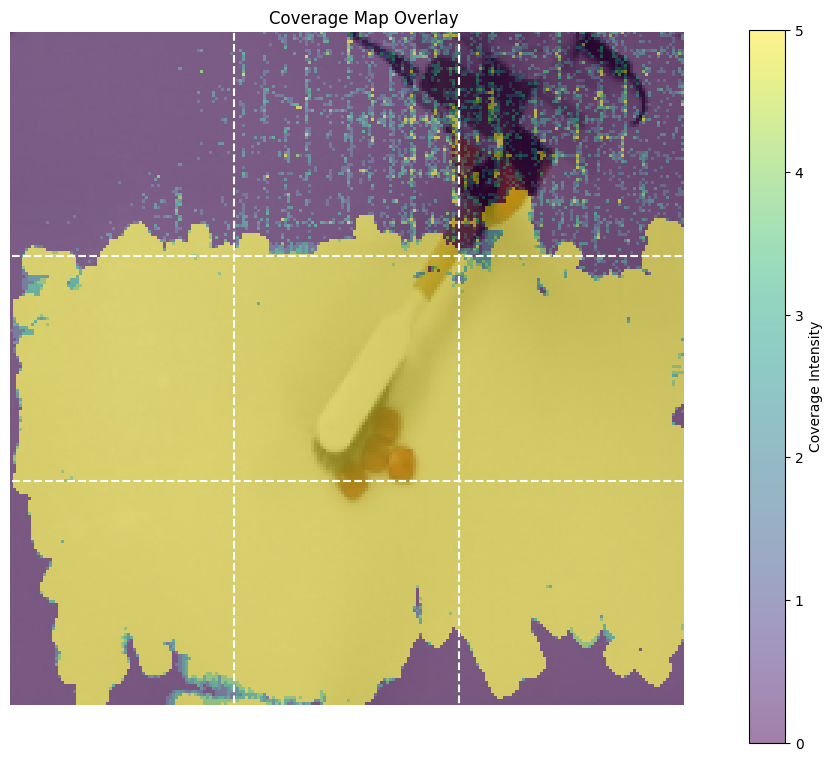

In [16]:
last_image = images[-1]  # Get the last image for visualization

# Normalize
# coverage_total /= coverage_total.max()

# Move to CPU for plotting
coverage_total = coverage_total.cpu()

# plot the coverage map over the last image
fig, ax = plt.subplots(figsize=(10, 10))
img1 = ax.imshow(last_image.cpu().numpy())
img2 = ax.imshow(coverage_total.cpu().numpy(), vmax=5, alpha=0.5, cmap="viridis")

ax.set_title("Coverage Map Overlay")
ax.axis("off")

# Attach colorbar to the same axes so it matches the height
cbar = fig.colorbar(img2, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Coverage Intensity")
# add vlines at each third of the image width
ax.vlines(x=coverage_total.shape[1] // 3, ymin=0, ymax=coverage_total.shape[0], color="white", linestyle="--")
ax.vlines(x=2 * coverage_total.shape[1] // 3, ymin=0, ymax=coverage_total.shape[0], color="white", linestyle="--")
ax.hlines(y=coverage_total.shape[1] // 3, xmin=0, xmax=coverage_total.shape[0], color="white", linestyle="--")
ax.hlines(y=2 * coverage_total.shape[1] // 3, xmin=0, xmax=coverage_total.shape[0], color="white", linestyle="--")

# save the figure
plt.savefig("coverage_map.png", dpi=300, bbox_inches="tight")